Import necessary dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [18]:
data = pd.read_csv('IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [59]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()

In [62]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

Extract time features

In [65]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [66]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [82]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

train_data_copy = train_data.copy()

split_idx_train_validate = int(len(train_data_copy) * 0.8)

# Training data is the first 80%
train_data = train_data_copy.iloc[:split_idx_train_validate]
# Validation data is the last 20%
validation_data = train_data_copy.iloc[split_idx_train_validate:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

X_validate = validation_data.drop('label', axis=1)
y_validate = validation_data['label']

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

In [86]:
X_train.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek',
       'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value',
       'FC3_Read_Holding_Register', 'FC4_Read_Coil'],
      dtype='object')

# Data preprocessing (Normalization)

In [87]:
feature_columns = X_train.columns
scaler = MinMaxScaler()

X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_validate[feature_columns] = scaler.fit_transform(X_validate[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183804 entries, 541 to 149866
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       183804 non-null  float32
 1   month                      183804 non-null  float32
 2   day                        183804 non-null  float32
 3   hour                       183804 non-null  float32
 4   minute                     183804 non-null  float32
 5   second                     183804 non-null  float32
 6   dayofweek                  183804 non-null  float32
 7   FC1_Read_Input_Register    183804 non-null  float32
 8   FC2_Read_Discrete_Value    183804 non-null  float32
 9   FC3_Read_Holding_Register  183804 non-null  float32
 10  FC4_Read_Coil              183804 non-null  float32
dtypes: float32(11)
memory usage: 9.1 MB


# Execution model
## Create model

In [89]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.linear_1 = nn.Linear(adjusted_hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        x = self.linear_1(last_time_step_out)
        out = self.linear_2(x)
        return out

Initialize model

In [90]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [91]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [92]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Construct Data Loader

In [93]:
batch_size = 128

# Use to_numpy is much better than .values
X_train_tensor: torch.Tensor = torch.tensor(X_train.to_numpy()).float().unsqueeze(1).to(device)
X_validate_tensor: torch.Tensor = torch.tensor(X_validate.to_numpy()).float().unsqueeze(1).to(device)

y_train_tensor: torch.Tensor = torch.tensor(y_train.to_numpy()).float().unsqueeze(1).to(device)
y_validate_tensor: torch.Tensor = torch.tensor(y_validate.to_numpy()).float().unsqueeze(1).to(device)


train_dataset: torch.utils.data.dataset.TensorDataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader: torch.utils.data.dataloader.DataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

validation_dataset: torch.utils.data.dataset.TensorDataset = TensorDataset(X_validate_tensor, y_validate_tensor)
validation_loader: torch.utils.data.dataloader.DataLoader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

Training model

In [106]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_loader:
        # Transfer data to GPU (Or CPU if non-cuda)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate indicators
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.sigmoid(outputs)
            
            loss = criterion(probabilities, labels)
            
            # Calculate indicators
            running_loss += loss.item() * inputs.size(0)

            predictions = (probabilities > 0.5).float().to(device)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(validation_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    
    pbar.update(1)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')

pbar.close()


 23%|██▎       | 23/100 [06:30<21:46, 16.97s/it]

  1%|          | 1/100 [00:08<14:35,  8.84s/it]

Epoch [1/100], Loss: 297.4833514145822, Accuracy: 0.3014515462122696



  2%|▏         | 2/100 [00:17<14:16,  8.74s/it]

Epoch [2/100], Loss: 296.08254790173265, Accuracy: 0.3014515462122696



  3%|▎         | 3/100 [00:26<14:02,  8.69s/it]

Epoch [3/100], Loss: 294.0915816955912, Accuracy: 0.3014515462122696



  4%|▍         | 4/100 [00:34<13:53,  8.68s/it]

Epoch [4/100], Loss: 295.27757159149417, Accuracy: 0.3014515462122696



  5%|▌         | 5/100 [00:43<13:44,  8.67s/it]

Epoch [5/100], Loss: 296.3207835898758, Accuracy: 0.3014515462122696



  6%|▌         | 6/100 [00:52<13:47,  8.80s/it]

Epoch [6/100], Loss: 298.9188309379939, Accuracy: 0.3014515462122696



  7%|▋         | 7/100 [01:01<13:58,  9.01s/it]

Epoch [7/100], Loss: 301.18496250276115, Accuracy: 0.3014515462122696



  8%|▊         | 8/100 [01:11<13:52,  9.05s/it]

Epoch [8/100], Loss: 304.4013273659523, Accuracy: 0.3014515462122696



  9%|▉         | 9/100 [01:20<13:41,  9.03s/it]

Epoch [9/100], Loss: 307.9607491373684, Accuracy: 0.3014515462122696



 10%|█         | 10/100 [01:29<13:31,  9.02s/it]

Epoch [10/100], Loss: 311.31947753788035, Accuracy: 0.3014515462122696



 11%|█         | 11/100 [01:37<13:17,  8.96s/it]

Epoch [11/100], Loss: 313.8401951965847, Accuracy: 0.3014515462122696



 12%|█▏        | 12/100 [01:46<13:06,  8.94s/it]

Epoch [12/100], Loss: 316.2711442247407, Accuracy: 0.3014515462122696



 13%|█▎        | 13/100 [01:55<12:58,  8.95s/it]

Epoch [13/100], Loss: 316.8257702100908, Accuracy: 0.3014515462122696



 14%|█▍        | 14/100 [02:04<12:51,  8.97s/it]

Epoch [14/100], Loss: 319.1122820261129, Accuracy: 0.3014515462122696



 15%|█▌        | 15/100 [02:14<12:54,  9.11s/it]

Epoch [15/100], Loss: 319.7923250918933, Accuracy: 0.3014515462122696



 16%|█▌        | 16/100 [02:23<12:45,  9.11s/it]

Epoch [16/100], Loss: 320.75271569951997, Accuracy: 0.3014515462122696


KeyboardInterrupt: 

Visualizing the training process

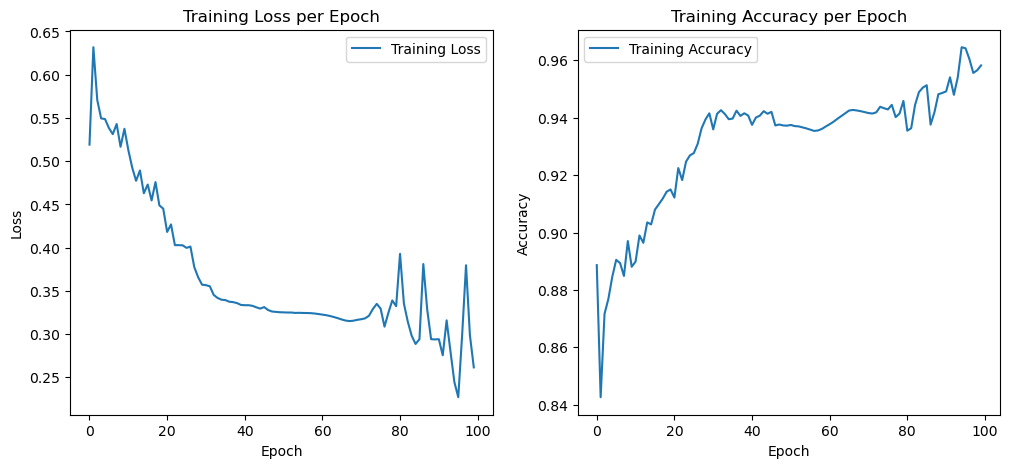

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [32]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.7325336443879594 , Precision:  0.3384642067380653 , Recall:  0.9866026289180991 , F1:  0.5040193704600484


Save model

In [35]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_{current_time}.pt"
torch.save(model.state_dict(), model_filename)

print("Model saved as:", model_filename)

Model saved as: model_2023-11-19_17-16-41.pt
